# Fase 3: Ground Truth Generation

Questo notebook genera il ground truth utilizzando i VIN comuni tra le due sorgenti.

## Obiettivi
1. Caricare i dataset allineati
2. Identificare coppie di record con VIN identici (match)
3. Generare coppie di non-match
4. Creare split train/validation/test
5. Salvare in `data/ground_truth/`

## Statistiche Attese
- Match: Coppie di record con stesso VIN
- Non-match: Coppie di record con VIN diversi
- Ratio: Tipicamente 1:1 o 1:2 (match:non-match)
- Split: 70% train, 10% validation, 20% test

## 1. Import Librerie

In [1]:
import sys
import os

# Aggiungi il percorso della cartella src al PYTHONPATH
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
sys.path.append(os.path.abspath('..'))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import moduli personalizzati
from src.ground_truth import GroundTruthGenerator

# Imposta stile grafici
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Librerie importate con successo!")

✓ Librerie importate con successo!


## 2. Caricamento Dataset Allineati

In [3]:
# Percorsi dei dataset allineati
craigslist_path = '../data/processed/craigslist_aligned.csv'
usedcars_path = '../data/processed/usedcars_aligned.csv'

# Carica i dataset
print("Caricamento dataset allineati...")
df_craigslist = pd.read_csv(craigslist_path, low_memory=False)
print(f"✓ Craigslist: {len(df_craigslist):,} righe, {len(df_craigslist.columns)} colonne")

df_usedcars = pd.read_csv(usedcars_path, low_memory=False)
print(f"✓ US Used Cars: {len(df_usedcars):,} righe, {len(df_usedcars.columns)} colonne")

print(f"\nColonne comuni: {set(df_craigslist.columns) & set(df_usedcars.columns)}")

Caricamento dataset allineati...
✓ Craigslist: 426,880 righe, 17 colonne
✓ US Used Cars: 3,000,040 righe, 14 colonne

Colonne comuni: {'transmission', 'model', 'cylinders', 'manufacturer', 'paint_color', 'drive', 'description', 'year', 'fuel', 'price', 'odometer', 'type', 'vin', 'source'}


## 2.1 Campionamento Dataset

Per gestire le dimensioni dei dataset e il tempo di elaborazione, lavoriamo con campioni rappresentativi:
- **Craigslist**: 10,000 record
- **US Used Cars**: 50,000 record

Questo garantisce ground truth allineato con le fasi successive (blocking e record linkage).

In [4]:
# Aggiungi record_id se non presente
if 'record_id' not in df_craigslist.columns:
    df_craigslist['record_id'] = 'craigslist_' + df_craigslist.index.astype(str)
if 'record_id' not in df_usedcars.columns:
    df_usedcars['record_id'] = 'usedcars_' + df_usedcars.index.astype(str)

# Campionamento con seed fisso per riproducibilità
print("\nCampionamento dataset...")
np.random.seed(42)

sample_size_craigslist = 10000
sample_size_usedcars = 50000

if len(df_craigslist) > sample_size_craigslist:
    df_craigslist = df_craigslist.sample(n=sample_size_craigslist, random_state=42)
    print(f"✓ Craigslist campionato: {len(df_craigslist):,} record")
else:
    print(f"✓ Craigslist: {len(df_craigslist):,} record (nessun campionamento necessario)")

if len(df_usedcars) > sample_size_usedcars:
    df_usedcars = df_usedcars.sample(n=sample_size_usedcars, random_state=42)
    print(f"✓ UsedCars campionato: {len(df_usedcars):,} record")
else:
    print(f"✓ UsedCars: {len(df_usedcars):,} record (nessun campionamento necessario)")

print("\n Ground truth sarà generato sui campioni per coerenza con Fase 4 e 5")


Campionamento dataset...
✓ Craigslist campionato: 10,000 record
✓ UsedCars campionato: 50,000 record

 Ground truth sarà generato sui campioni per coerenza con Fase 4 e 5


## 3. Analisi VIN

In [5]:
# Statistiche VIN
print("STATISTICHE VIN:")
print("=" * 80)
print("\nCraigslist:")
print(f"  - Totale record: {len(df_craigslist):,}")
print(f"  - VIN non nulli: {df_craigslist['vin'].notna().sum():,}")
print(f"  - VIN validi (>=11 caratteri): {(df_craigslist['vin'].str.len() >= 11).sum():,}")
print(f"  - VIN unici: {df_craigslist['vin'].nunique():,}")

print("\nUS Used Cars:")
print(f"  - Totale record: {len(df_usedcars):,}")
print(f"  - VIN non nulli: {df_usedcars['vin'].notna().sum():,}")
print(f"  - VIN validi (>=11 caratteri): {(df_usedcars['vin'].str.len() >= 11).sum():,}")
print(f"  - VIN unici: {df_usedcars['vin'].nunique():,}")

STATISTICHE VIN:

Craigslist:
  - Totale record: 10,000
  - VIN non nulli: 6,198
  - VIN validi (>=11 caratteri): 6,196
  - VIN unici: 5,617

US Used Cars:
  - Totale record: 50,000
  - VIN non nulli: 49,989
  - VIN validi (>=11 caratteri): 49,984
  - VIN unici: 49,989


In [6]:
# Trova VIN comuni
vins_craigslist = set(df_craigslist[df_craigslist['vin'].notna()]['vin'])
vins_usedcars = set(df_usedcars[df_usedcars['vin'].notna()]['vin'])

common_vins = vins_craigslist & vins_usedcars

print("\nVIN COMUNI TRA LE DUE SORGENTI:")
print("=" * 80)
print(f"VIN in Craigslist: {len(vins_craigslist):,}")
print(f"VIN in US Used Cars: {len(vins_usedcars):,}")
print(f"VIN comuni: {len(common_vins):,}")
print(f"\nPotenziali match da VIN comuni: {len(common_vins):,}")


VIN COMUNI TRA LE DUE SORGENTI:
VIN in Craigslist: 5,617
VIN in US Used Cars: 49,989
VIN comuni: 4

Potenziali match da VIN comuni: 4


## 4. Generazione Ground Truth

In [7]:
# Crea generatore di ground truth
print("Creazione generatore ground truth...")
gt_generator = GroundTruthGenerator(
    df1=df_craigslist,
    df2=df_usedcars,
    vin_column='vin',
    min_vin_length=11
)
print("✓ Generatore creato")

Creazione generatore ground truth...
✓ Generatore creato


In [8]:
# Trova match basati su VIN
print("\nRicerca match basati su VIN...")
matches = gt_generator.find_matches()

print(f"\n✓ Match trovati: {len(matches):,}")
print("\nCampione di match:")
display(matches.head(10))


Ricerca match basati su VIN...
Pulizia VIN in corso...
DF1: 10000 -> 5615 record con VIN validi
DF2: 50000 -> 49984 record con VIN validi
VIN comuni trovati: 4
Coppie di match generate: 4

✓ Match trovati: 4

Campione di match:


,record_id_1,record_id_2,vin,label
0,df1_4370,df2_22704,KMTG64LA9LU062391,1
1,df1_7759,df2_39040,1GJZ71FGXB1118446,1
2,df1_9945,df2_33077,SCBBR93W07C047494,1
3,df1_963,df2_29273,1J4BA5H1XAL152698,1


In [9]:
# Genera non-match
print("\nGenerazione non-match...")
non_matches = gt_generator.generate_non_matches(
    ratio=1.0  # Stesso numero di match (ratio 1:1)
)

print(f"\n✓ Non-match generati: {len(non_matches):,}")
print("\nCampione di non-match:")
display(non_matches.head(10))


Generazione non-match...
Pulizia VIN in corso...
DF1: 10000 -> 5615 record con VIN validi
DF2: 50000 -> 49984 record con VIN validi
Generazione di 4 non-match...
Non-match generati: 4

✓ Non-match generati: 4

Campione di non-match:


,record_id_1,record_id_2,vin_1,vin_2,label
0,df1_7219,df2_3004,5TDZK3DC3GS695265,MAJ3S2GE6LC356286,0
1,df1_6051,df2_17587,1FTBR1C88LKB16710,3C6TR5CJ7LG193887,0
2,df1_8426,df2_36573,3C6TR5HT8FG691322,1G4GE5G33CF200770,0
3,df1_9220,df2_10302,2G4WS52JX11240195,5YMGY0C57CLK27954,0


## 5. Creazione Dataset Ground Truth Completo

In [10]:
# Crea ground truth completo
ground_truth = gt_generator.create_ground_truth()

print("GROUND TRUTH COMPLETO:")
print("=" * 80)
print(f"Totale coppie: {len(ground_truth):,}")
print("\nDistribuzione label:")
print(ground_truth['label'].value_counts())
print(f"\nPercentuale match: {(ground_truth['label'].sum() / len(ground_truth) * 100):.2f}%")

print("\nCampione ground truth:")
display(ground_truth.head(10))

Ground truth totale: 8 coppie
  - Match: 4
  - Non-match: 4
GROUND TRUTH COMPLETO:
Totale coppie: 8

Distribuzione label:
label
1    4
0    4
Name: count, dtype: int64

Percentuale match: 50.00%

Campione ground truth:


,record_id_1,record_id_2,vin,label,vin_1,vin_2,price_1,price_2,year_1,year_2,...,size_1,size_2,type_1,type_2,paint_color_1,paint_color_2,state_1,state_2,description_1,description_2
0,df1_7759,df2_39040,1GJZ71FGXB1118446,1,NaN,NaN,16995.0,17995.0,2011.0,2011,...,NaN,None,van,Van,blue,Blue,ct,None,2011 GMC Savana Passenger LT 3500 15 Passenger...,Fresh Trade in vehicle from a New Car dealersh...
1,df1_6051,df2_17587,NaN,0,1FTBR1C88LKB16710,3C6TR5CJ7LG193887,42990.0,51458.0,2020.0,2020,...,NaN,None,van,Pickup Truck,white,Bright White Clearcoat,mi,None,2020 Ford Transit Cargo Van Mid Roof Cargo -- ...,Call 470-397-1298 to speak to an expert!!! Fa...
2,df1_4370,df2_22704,KMTG64LA9LU062391,1,NaN,NaN,30990.0,36515.0,2020.0,2020,...,NaN,None,sedan,Sedan,NaN,Gray,oh,None,Carvana is the safer way to buy a car During t...,[!@@Additional Info@@!]Multi-Adjustable Front ...
3,df1_9220,df2_10302,NaN,0,2G4WS52JX11240195,5YMGY0C57CLK27954,2999.0,22999.0,2001.0,2012,...,NaN,None,sedan,SUV / Crossover,black,Black,oh,None,This 2001 Buick Century has been SOLD but call...,This BMW X5 is an excellent value for the mone...
4,df1_9945,df2_33077,SCBBR93W07C047494,1,NaN,NaN,38900.0,38900.0,2007.0,2007,...,NaN,None,sedan,Sedan,custom,Gold,wi,None,2007 Bentley Continental Flying Spur Sedan - $...,Visit MSI Auto Sales online at www.usedcarsinm...
5,df1_7219,df2_3004,NaN,0,5TDZK3DC3GS695265,MAJ3S2GE6LC356286,15995.0,22290.0,2016.0,2020,...,NaN,None,other,SUV / Crossover,white,DIAMOND,fl,None,This Toyota Sienna can be yours today!If you h...,We are excited to offer this 2020 Ford EcoSpor...
6,df1_963,df2_29273,1J4BA5H1XAL152698,1,NaN,NaN,24500.0,21799.0,2010.0,2010,...,NaN,None,SUV,SUV / Crossover,NaN,Stone White Clearcoat,co,None,2010 Jeep Wrangler Unlimited Unlimited Sahara ...,2010 Jeep Wrangler Unlimited Sahara 6-Speed Ma...
7,df1_8426,df2_36573,NaN,0,3C6TR5HT8FG691322,1G4GE5G33CF200770,23998.0,9695.0,2015.0,2012,...,NaN,None,NaN,Sedan,NaN,BLACK,nc,None,2015 RAM 2500 4WD Crew Cab with LIFT Oak Ridg...,*2012 BUICK LACROSSE AWD * Drive this vehicle ...



Distribuzione Label nel Ground Truth:
Match (1): 4
Non-Match (0): 4


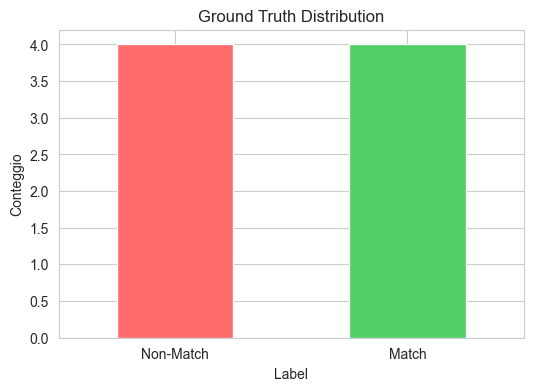

In [11]:
# Visualizza distribuzione label
print("\nDistribuzione Label nel Ground Truth:")
print("="*50)
counts = ground_truth['label'].value_counts()
for label, count in counts.items():
    label_name = 'Match' if label == 1 else 'Non-Match'
    print(f"{label_name} ({label}): {count:,}")
print("="*50)

# Grafico
ground_truth['label'].value_counts().plot(kind='bar', figsize=(6, 4), color=['#ff6b6b', '#51cf66'])
plt.xlabel('Label')
plt.ylabel('Conteggio')
plt.title('Ground Truth Distribution')
plt.xticks([0, 1], ['Non-Match', 'Match'], rotation=0)
plt.savefig('../results/visualizations/ground_truth_distribution.png', dpi=300)
plt.show()

## 6. Split Train/Validation/Test

In [12]:
# Ricarica modulo dopo modifiche
import importlib
import src.ground_truth
importlib.reload(src.ground_truth)
from src.ground_truth import GroundTruthGenerator

# Split del ground truth
print("Creazione split train/validation/test...")

train, validation, test = gt_generator.split_ground_truth(
    ground_truth=ground_truth,
    test_size=0.2,
    val_size=0.1,
    random_state=42
)

print("\nSTATISTICHE SPLIT:")
print("=" * 80)
print(f"Training set:   {len(train):,} coppie ({len(train)/len(ground_truth)*100:.1f}%)")
print(f"  - Match:      {train['label'].sum():,}")
print(f"  - Non-match:  {len(train) - train['label'].sum():,}")

print(f"\nValidation set: {len(validation):,} coppie ({len(validation)/len(ground_truth)*100:.1f}%)")
print(f"  - Match:      {validation['label'].sum():,}")
print(f"  - Non-match:  {len(validation) - validation['label'].sum():,}")

print(f"\nTest set:       {len(test):,} coppie ({len(test)/len(ground_truth)*100:.1f}%)")
print(f"  - Match:      {test['label'].sum():,}")
print(f"  - Non-match:  {len(test) - test['label'].sum():,}")

Creazione split train/validation/test...
Split completato:
  - Training: 5 (62.5%)
  - Validation: 1 (12.5%)
  - Test: 2 (25.0%)

STATISTICHE SPLIT:
Training set:   5 coppie (62.5%)
  - Match:      2
  - Non-match:  3

Validation set: 1 coppie (12.5%)
  - Match:      1
  - Non-match:  0

Test set:       2 coppie (25.0%)
  - Match:      1
  - Non-match:  1


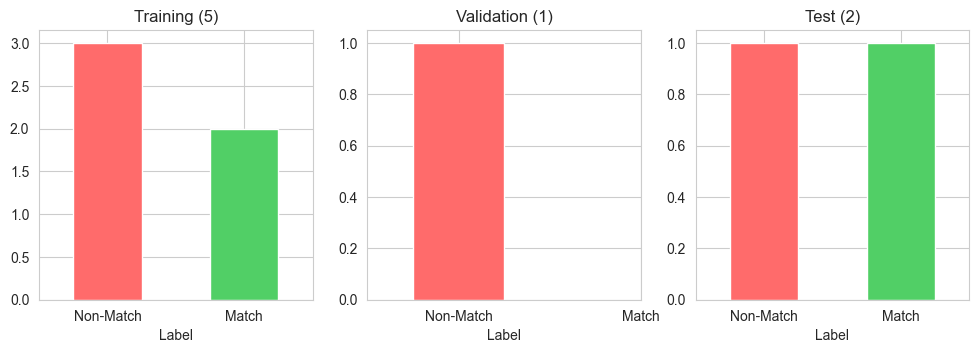

In [13]:
# Visualizza distribuzione split
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

for idx, (data, name) in enumerate([(train, 'Training'), (validation, 'Validation'), (test, 'Test')]):
    data['label'].value_counts().plot(kind='bar', ax=axes[idx], color=['#ff6b6b', '#51cf66'])
    axes[idx].set_title(f'{name} ({len(data):,})')
    axes[idx].set_xlabel('Label')
    axes[idx].set_xticks([0, 1])
    axes[idx].set_xticklabels(['Non-Match', 'Match'], rotation=0)

plt.savefig('../results/visualizations/ground_truth_splits.png', dpi=300)
plt.show()

## 7. Salvataggio Ground Truth

In [14]:
# Crea directory se non esiste
os.makedirs('../data/ground_truth', exist_ok=True)

# Salva i file
print("Salvataggio ground truth...")

train.to_csv('../data/ground_truth/train.csv', index=False)
print(f"✓ Training salvato: data/ground_truth/train.csv ({len(train):,} coppie)")

validation.to_csv('../data/ground_truth/validation.csv', index=False)
print(f"✓ Validation salvato: data/ground_truth/validation.csv ({len(validation):,} coppie)")

test.to_csv('../data/ground_truth/test.csv', index=False)
print(f"✓ Test salvato: data/ground_truth/test.csv ({len(test):,} coppie)")

ground_truth.to_csv('../data/ground_truth/ground_truth_full.csv', index=False)
print(f"✓ Ground truth completo salvato: data/ground_truth/ground_truth_full.csv ({len(ground_truth):,} coppie)")

print("Fase 3 completata con successo!")

Salvataggio ground truth...
✓ Training salvato: data/ground_truth/train.csv (5 coppie)
✓ Validation salvato: data/ground_truth/validation.csv (1 coppie)
✓ Test salvato: data/ground_truth/test.csv (2 coppie)
✓ Ground truth completo salvato: data/ground_truth/ground_truth_full.csv (8 coppie)
Fase 3 completata con successo!


In [15]:
# Salva anche i dataset campionati per uso nelle fasi successive
print("\nSalvataggio dataset campionati...")

df_craigslist.to_csv('../data/processed/craigslist_sample.csv', index=False)
print(f"✓ Craigslist sample salvato: data/processed/craigslist_sample.csv ({len(df_craigslist):,} records)")

df_usedcars.to_csv('../data/processed/usedcars_sample.csv', index=False)
print(f"✓ UsedCars sample salvato: data/processed/usedcars_sample.csv ({len(df_usedcars):,} records)")

print("\nQuesti campioni saranno usati nelle Fasi 4 e 5 per garantire coerenza con il ground truth")


Salvataggio dataset campionati...
✓ Craigslist sample salvato: data/processed/craigslist_sample.csv (10,000 records)
✓ UsedCars sample salvato: data/processed/usedcars_sample.csv (50,000 records)

Questi campioni saranno usati nelle Fasi 4 e 5 per garantire coerenza con il ground truth


## 8. Verifica Qualità Ground Truth

In [16]:
# Carica un campione di match e verifica manualmente
print("VERIFICA QUALITÀ GROUND TRUTH:")
print("=" * 80)

# Prendi match casuali (massimo 5 o meno se non disponibili)
n_matches = train[train['label'] == 1].shape[0]
n_samples = min(5, n_matches)

if n_samples == 0:
    print("\n Nessun match disponibile nel training set per la verifica")
else:
    sample_matches = train[train['label'] == 1].sample(n_samples, random_state=42)
    
    for i, (idx, row) in enumerate(sample_matches.iterrows(), 1):
        rec1_id = row['record_id_1']
        rec2_id = row['record_id_2']
        
        # Trova i record originali
        rec1 = gt_generator.df1[gt_generator.df1['record_id'] == rec1_id].iloc[0]
        rec2 = gt_generator.df2[gt_generator.df2['record_id'] == rec2_id].iloc[0]
        
        print(f"\n{'='*80}")
        print(f"MATCH #{i} - VIN: {row['vin']}")
        print(f"{'-'*80}")
        print("Craigslist:")
        print(f"  Year: {rec1.get('year')} | Make: {rec1.get('manufacturer')} | Model: {rec1.get('model')}")
        print(f"  Price: ${rec1.get('price'):,.0f} | Odometer: {rec1.get('odometer'):,.0f}")
        print("\nUS Used Cars:")
        print(f"  Year: {rec2.get('year')} | Make: {rec2.get('manufacturer')} | Model: {rec2.get('model')}")
        print(f"  Price: ${rec2.get('price'):,.0f} | Odometer: {rec2.get('odometer'):,.0f}")

VERIFICA QUALITÀ GROUND TRUTH:

MATCH #1 - VIN: 1J4BA5H1XAL152698
--------------------------------------------------------------------------------
Craigslist:
  Year: 2010.0 | Make: jeep | Model: wrangler unlimited
  Price: $24,500 | Odometer: 81,079

US Used Cars:
  Year: 2010 | Make: jeep | Model: Wrangler Unlimited
  Price: $21,799 | Odometer: 81,021

MATCH #2 - VIN: KMTG64LA9LU062391
--------------------------------------------------------------------------------
Craigslist:
  Year: 2020.0 | Make: nan | Model: Genesis G70 2.0T Sedan 4D
  Price: $30,990 | Odometer: 2,308

US Used Cars:
  Year: 2020 | Make: genesis | Model: G70
  Price: $36,515 | Odometer: 8


## 9. Riepilogo e Statistiche Finali

In [ ]:
# Crea report riepilogativo
report = f"""
{'='*80}
REPORT GROUND TRUTH GENERATION
{'='*80}

DATASET SORGENTE:
  - Craigslist:    {len(df_craigslist):,} record
  - US Used Cars:  {len(df_usedcars):,} record

VIN ANALYSIS:
  - VIN comuni:    {len(common_vins):,}
  - Match generati: {len(matches):,}
  - Non-match generati: {len(non_matches):,}

GROUND TRUTH:
  - Totale coppie: {len(ground_truth):,}
  - Match:         {ground_truth['label'].sum():,} ({ground_truth['label'].sum()/len(ground_truth)*100:.1f}%)
  - Non-match:     {len(ground_truth) - ground_truth['label'].sum():,} ({(len(ground_truth) - ground_truth['label'].sum())/len(ground_truth)*100:.1f}%)

SPLIT:
  - Training:      {len(train):,} coppie ({len(train)/len(ground_truth)*100:.1f}%)
  - Validation:    {len(validation):,} coppie ({len(validation)/len(ground_truth)*100:.1f}%)
  - Test:          {len(test):,} coppie ({len(test)/len(ground_truth)*100:.1f}%)

FILE GENERATI:
  ✓ data/ground_truth/train.csv
  ✓ data/ground_truth/validation.csv
  ✓ data/ground_truth/test.csv
  ✓ data/ground_truth/ground_truth_full.csv

{'='*80}
"""

print(report)

# Salva report
with open('../results/ground_truth_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)
print("✓ Report salvato in: results/ground_truth_report.txt")


REPORT GROUND TRUTH GENERATION

DATASET SORGENTE:
  - Craigslist:    10,000 record
  - US Used Cars:  50,000 record

VIN ANALYSIS:
  - VIN comuni:    4
  - Match generati: 4
  - Non-match generati: 4

GROUND TRUTH:
  - Totale coppie: 8
  - Match:         4 (50.0%)
  - Non-match:     4 (50.0%)

SPLIT:
  - Training:      5 coppie (62.5%)
  - Validation:    1 coppie (12.5%)
  - Test:          2 coppie (25.0%)

FILE GENERATI:
  ✓ data/ground_truth/train.csv
  ✓ data/ground_truth/validation.csv
  ✓ data/ground_truth/test.csv
  ✓ data/ground_truth/ground_truth_full.csv


✓ Report salvato in: results/ground_truth_report.txt


: 